In [122]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

데이터 로드 및 확인

In [85]:
df = pd.read_csv('BP_data.csv')  # CSV 파일 경로
df

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


파이 차트

<AxesSubplot:ylabel='count'>

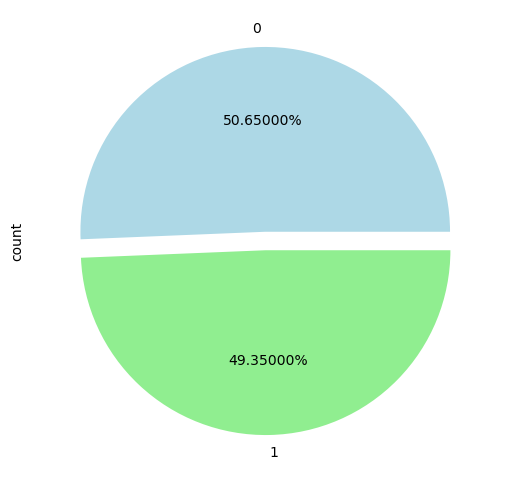

In [86]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# 파이 차트 그리기
df['Blood_Pressure_Abnormality'].value_counts().plot(
    kind='pie',
    autopct='%0.05f%%',
    colors=['lightblue', 'lightgreen'],  # 두 가지 색상 사용
    explode=(0.05, 0.05),  # explode를 2개 값으로 설정
)

컬럼

In [87]:
df.columns

Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')

결측치 제거

In [88]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Pregnancy                        0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64

타겟 변수

In [89]:
# 데이터와 타겟 분리
X = df.drop('Blood_Pressure_Abnormality', axis=1).values
y = df['Blood_Pressure_Abnormality'].values

데이터 정규화

In [90]:
# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

데이터 분할

In [92]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((254, 14), (64, 14), (254,), (64,))

PyTorch 텐서로 데이터 변환

In [93]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

DataLoader

In [94]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

모델 정의

In [95]:
class BloodPressureRegression(nn.Module):
    def __init__(self, input_size=14):
        super(BloodPressureRegression, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
    )


    def forward(self, x):
        return self.model(x)

# Device configuration (cuda if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.numpy()),
    y=y_train.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model
model = BloodPressureRegression().to(device)

# Loss function and optimizer for regression 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

학습 및 모델 평가

In [96]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6881, Accuracy: 65.62%
Epoch 2/20, Loss: 0.6647, Accuracy: 71.88%
Epoch 3/20, Loss: 0.6234, Accuracy: 71.88%
Epoch 4/20, Loss: 0.5843, Accuracy: 73.44%
Epoch 5/20, Loss: 0.5488, Accuracy: 73.44%
Epoch 6/20, Loss: 0.5207, Accuracy: 71.88%
Epoch 7/20, Loss: 0.4944, Accuracy: 71.88%
Epoch 8/20, Loss: 0.4722, Accuracy: 75.00%
Epoch 9/20, Loss: 0.4841, Accuracy: 73.44%
Epoch 10/20, Loss: 0.4184, Accuracy: 75.00%
Epoch 11/20, Loss: 0.4369, Accuracy: 75.00%
Epoch 12/20, Loss: 0.4107, Accuracy: 73.44%
Epoch 13/20, Loss: 0.3994, Accuracy: 75.00%
Epoch 14/20, Loss: 0.3609, Accuracy: 71.88%
Epoch 15/20, Loss: 0.4253, Accuracy: 75.00%
Epoch 16/20, Loss: 0.4227, Accuracy: 70.31%
Epoch 17/20, Loss: 0.3970, Accuracy: 76.56%
Epoch 18/20, Loss: 0.3482, Accuracy: 71.88%
Epoch 19/20, Loss: 0.3166, Accuracy: 73.44%
Epoch 20/20, Loss: 0.3553, Accuracy: 73.44%
Training complete.


모델 평가

In [97]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[18  9]
 [ 8 29]]
F1 Score: 0.73
Precision: 0.73
Recall: 0.73
Specificity: 0.73


손실과 정확도 시각화

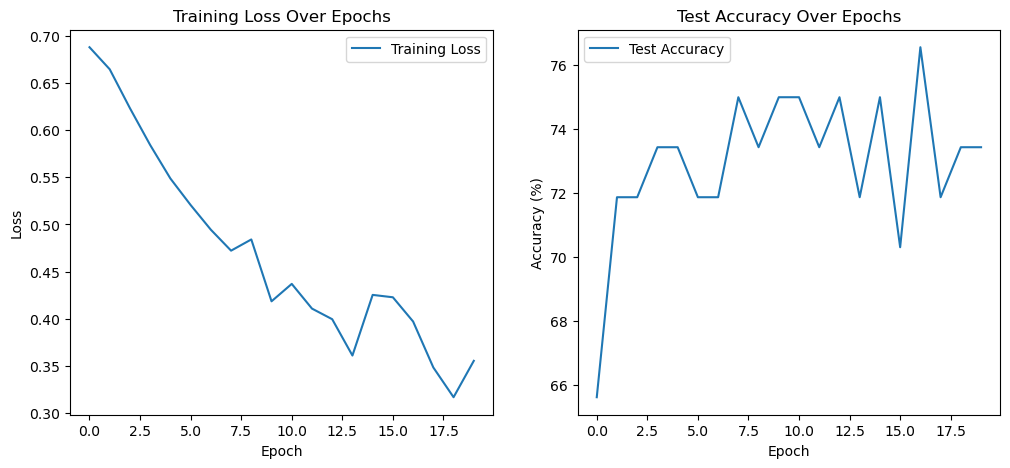

In [98]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

산점도

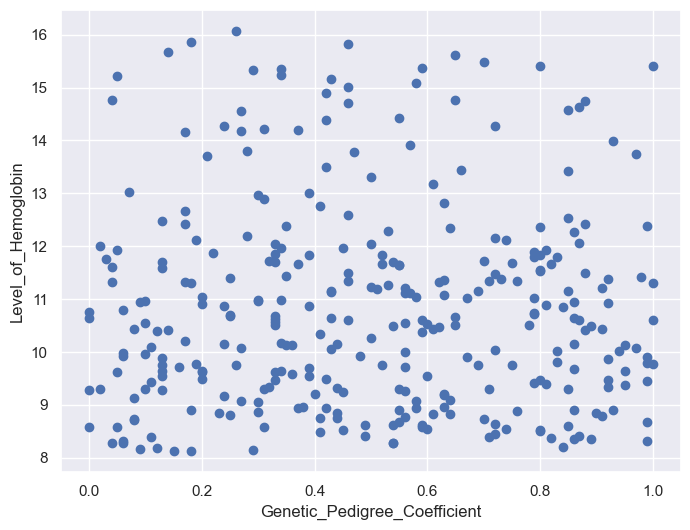

In [117]:
# 산점도 확인
plt.scatter(df['Genetic_Pedigree_Coefficient'], df['Level_of_Hemoglobin'])
plt.xlabel('Genetic_Pedigree_Coefficient')
plt.ylabel('Level_of_Hemoglobin')

plt.show()

히트맵

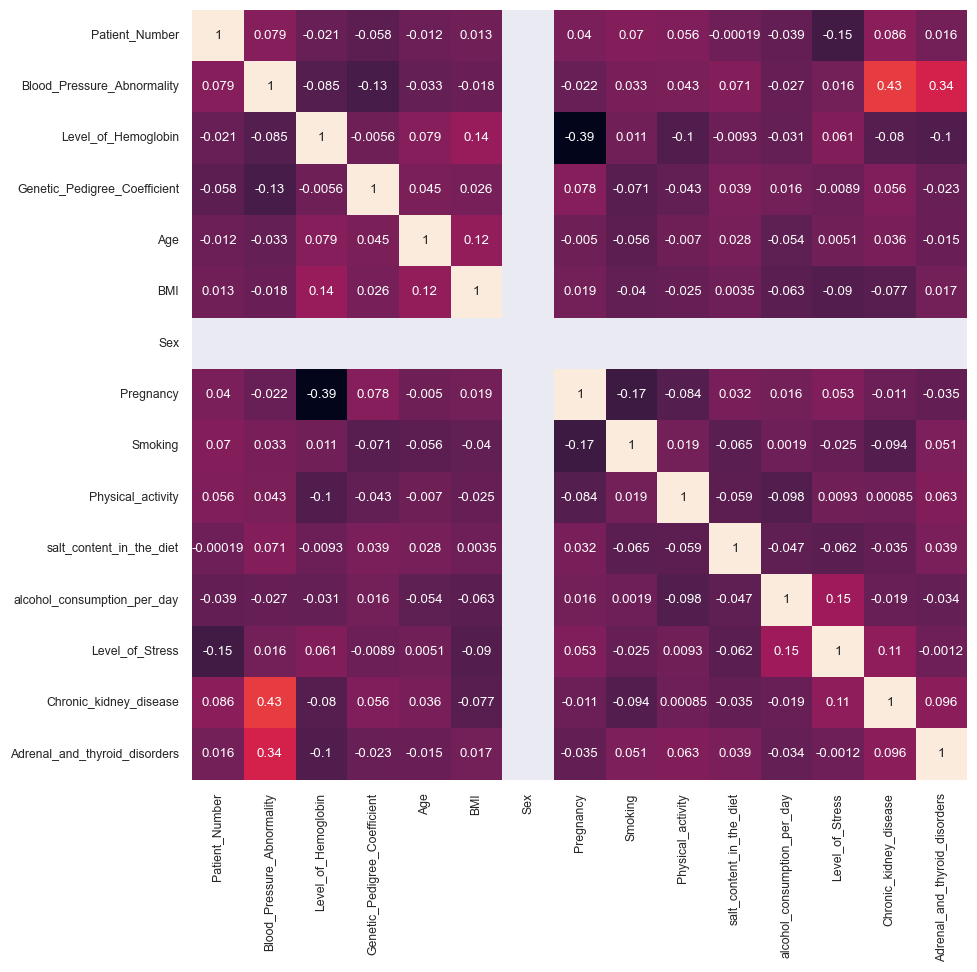

In [119]:
df_corr=df.corr()

#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

레이블 개수 확인

Text(0.5, 1.0, 'Label')

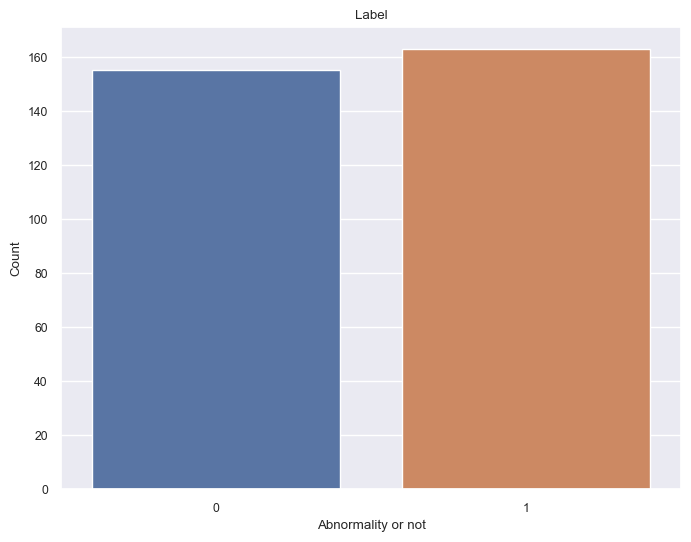

In [120]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="Blood_Pressure_Abnormality")
plt.xlabel("Abnormality or not")
plt.ylabel("Count")
plt.title("Label")  